<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Perceiver/Perceiver_for_Optical_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: it's advised to run this notebook on GPU, for faster inference.

## Set up environment

First, we install HuggingFace Transformers.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 15.8 MB/s 
     |████████████████████████████████| 3.3 MB 72.8 MB/s 
     |████████████████████████████████| 895 kB 72.4 MB/s 
     |████████████████████████████████| 61 kB 630 kB/s 


## Load images

Here we download 2 frames from the [Sintel](http://sintel.is.tue.mpg.de/) dataset, for which we are going to predict the optical flow of the pixels of the first frame relative to the second.

In [2]:
import requests
from PIL import Image

urls = ["https://storage.googleapis.com/perceiver_io/sintel_frame1.png", "https://storage.googleapis.com/perceiver_io/sintel_frame2.png"]

image1 = Image.open(requests.get(urls[0], stream=True).raw)
image2 = Image.open(requests.get(urls[1], stream=True).raw)

Let's visualize both:

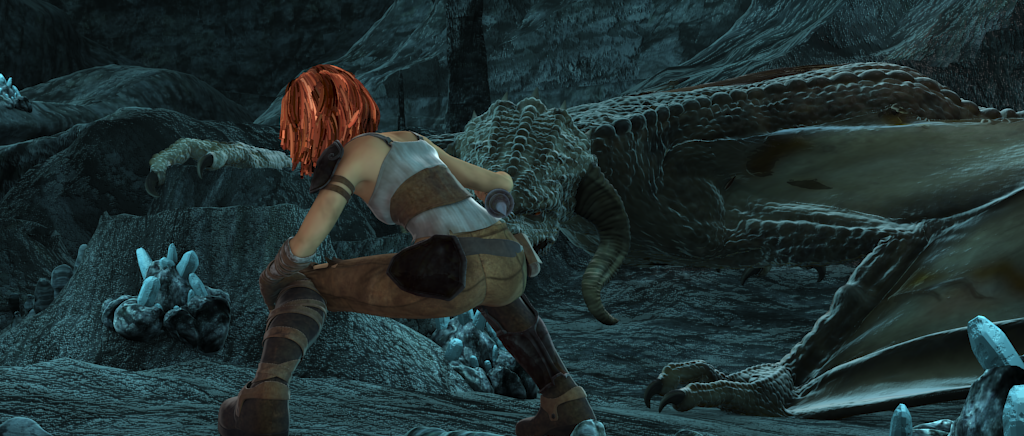

In [3]:
display(image1)

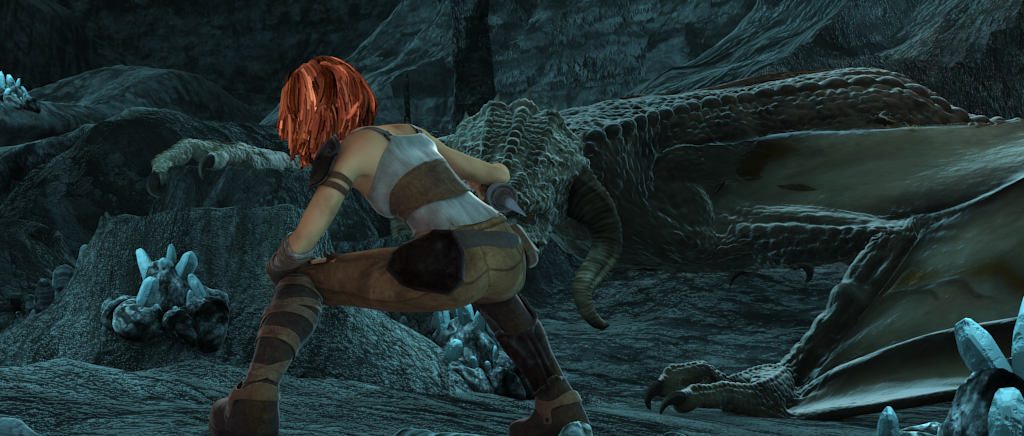

In [4]:
display(image2)

In [5]:
image1.save("image1.png")

In [6]:
image2.save("image2.png")

## Step 1: define helper functions

We first define some helper functions, namely one to normalize the images, and one that will extract 3x3 patches around each pixel from the images (as described in the paper).

In [7]:
import math
import torch.nn.functional as F

def normalize(im):
  return im / 255.0 * 2 - 1

# source: https://discuss.pytorch.org/t/tf-extract-image-patches-in-pytorch/43837/9
def extract_image_patches(x, kernel, stride=1, dilation=1):
    # Do TF 'SAME' Padding
    b,c,h,w = x.shape
    h2 = math.ceil(h / stride)
    w2 = math.ceil(w / stride)
    pad_row = (h2 - 1) * stride + (kernel - 1) * dilation + 1 - h
    pad_col = (w2 - 1) * stride + (kernel - 1) * dilation + 1 - w
    x = F.pad(x, (pad_row//2, pad_row - pad_row//2, pad_col//2, pad_col - pad_col//2))
    
    # Extract patches
    patches = x.unfold(2, kernel, stride).unfold(3, kernel, stride)
    patches = patches.permute(0,4,5,1,2,3).contiguous()
    
    return patches.view(b,-1,patches.shape[-2], patches.shape[-1])

## Step 2: define forward pass

The authors of Perceiver trained the model on a resolution of 368x496 on [AutoFlow](https://arxiv.org/abs/2104.14544), a large-scale dataset of 400,000 synthetic image pairs. 

However, the images above have a different resolution. Therefore, one splits up the images above into patches of size 368x496, then perform a forward pass for each patch to compute the flow, and finally stitch the computed flows together.

The function below implements this.

In [8]:
import torch
import numpy as np

def compute_optical_flow(model, img1, img2, grid_indices, FLOW_SCALE_FACTOR = 20):
  """Function to compute optical flow between two images.

  To compute the flow between images of arbitrary sizes, we divide the image
  into patches, compute the flow for each patch, and stitch the flows together.

  Args:
    model: PyTorch Perceiver model 
    img1: first image
    img2: second image
    grid_indices: indices of the upper left corner for each patch.
  """
  img1 = torch.tensor(np.moveaxis(img1, -1, 0))
  img2 = torch.tensor(np.moveaxis(img2, -1, 0))
  imgs = torch.stack([img1, img2], dim=0)[None]
  height = imgs.shape[-2]
  width = imgs.shape[-1]

  #print("Shape of imgs after stacking:", imgs.shape)

  patch_size = model.config.train_size
  
  if height < patch_size[0]:
    raise ValueError(
        f"Height of image (shape: {imgs.shape}) must be at least {patch_size[0]}."
        "Please pad or resize your image to the minimum dimension."
    )
  if width < patch_size[1]:
    raise ValueError(
        f"Width of image (shape: {imgs.shape}) must be at least {patch_size[1]}."
        "Please pad or resize your image to the minimum dimension."
    )

  flows = 0
  flow_count = 0

  for y, x in grid_indices:    
    imgs = torch.stack([img1, img2], dim=0)[None]
    inp_piece = imgs[..., y : y + patch_size[0],
                     x : x + patch_size[1]]
        
    print("Shape of inp_piece:", inp_piece.shape)
    
    batch_size, _, C, H, W = inp_piece.shape
    patches = extract_image_patches(inp_piece.view(batch_size*2,C,H,W), kernel=3)
    _, C, H, W = patches.shape
    patches = patches.view(batch_size, -1, C, H, W).float().to(model.device)
        
    # actual forward pass
    with torch.no_grad():
      output = model(inputs=patches).logits * FLOW_SCALE_FACTOR
    
    # the code below could also be implemented in PyTorch
    flow_piece = output.cpu().detach().numpy()
    
    weights_x, weights_y = np.meshgrid(
        torch.arange(patch_size[1]), torch.arange(patch_size[0]))

    weights_x = np.minimum(weights_x + 1, patch_size[1] - weights_x)
    weights_y = np.minimum(weights_y + 1, patch_size[0] - weights_y)
    weights = np.minimum(weights_x, weights_y)[np.newaxis, :, :,
                                                np.newaxis]
    padding = [(0, 0), (y, height - y - patch_size[0]),
               (x, width - x - patch_size[1]), (0, 0)]
    flows += np.pad(flow_piece * weights, padding)
    flow_count += np.pad(weights, padding)

    # delete activations to avoid OOM
    del output

  flows /= flow_count
  return flows

## Step 3: run

We first instantiate the trained model from the hub.

In [9]:
from transformers import PerceiverForOpticalFlow
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PerceiverForOpticalFlow.from_pretrained("deepmind/optical-flow-perceiver")
model.to(device)

Downloading:   0%|          | 0.00/914 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/157M [00:00<?, ?B/s]

PerceiverForOpticalFlow(
  (perceiver): PerceiverModel(
    (input_preprocessor): PerceiverImagePreprocessor(
      (position_embeddings): PerceiverFourierPositionEncoding()
      (positions_projection): Identity()
      (conv_after_patches): Linear(in_features=54, out_features=64, bias=True)
    )
    (embeddings): PerceiverEmbeddings()
    (encoder): PerceiverEncoder(
      (cross_attention): PerceiverLayer(
        (attention): PerceiverAttention(
          (self): PerceiverSelfAttention(
            (layernorm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (layernorm2): LayerNorm((322,), eps=1e-05, elementwise_affine=True)
            (query): Linear(in_features=512, out_features=322, bias=True)
            (key): Linear(in_features=322, out_features=322, bias=True)
            (value): Linear(in_features=322, out_features=322, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): PerceiverSelfOutput(
            (dens

In [10]:
import itertools

TRAIN_SIZE = model.config.train_size

def compute_grid_indices(image_shape, patch_size=TRAIN_SIZE, min_overlap=20):
  if min_overlap >= TRAIN_SIZE[0] or min_overlap >= TRAIN_SIZE[1]:
    raise ValueError(
        f"Overlap should be less than size of patch (got {min_overlap}"
        f"for patch size {patch_size}).")
  ys = list(range(0, image_shape[0], TRAIN_SIZE[0] - min_overlap))
  xs = list(range(0, image_shape[1], TRAIN_SIZE[1] - min_overlap))
  # Make sure the final patch is flush with the image boundary
  ys[-1] = image_shape[0] - patch_size[0]
  xs[-1] = image_shape[1] - patch_size[1]
  return itertools.product(ys, xs)

Let's compute the flow!

In [11]:
im1 = np.array(image1)
im2 = np.array(image2)

# Divide images into patches, compute flow between corresponding patches
# of both images, and stitch the flows together
grid_indices = compute_grid_indices(im1.shape)
flow = compute_optical_flow(model, normalize(im1), normalize(im2), grid_indices)

Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])


## Visualize flow

Finally, let's visualize the prediction.

In [12]:
import cv2
import matplotlib.pyplot as plt

def visualize_flow(flow):
  flow = np.array(flow)
  # Use Hue, Saturation, Value colour model 
  hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
  hsv[..., 2] = 255

  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
  hsv[..., 0] = ang / np.pi / 2 * 180
  hsv[..., 1] = np.clip(mag * 255 / 24, 0, 255)
  bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  plt.imshow(bgr)

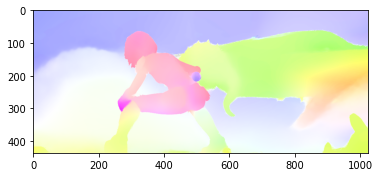

In [13]:
visualize_flow(flow[0])

## Gradio demo

In [14]:
!pip install -q gradio

     |████████████████████████████████| 979 kB 14.8 MB/s 
     |████████████████████████████████| 206 kB 69.0 MB/s 
     |████████████████████████████████| 2.0 MB 51.7 MB/s 
     |████████████████████████████████| 63 kB 2.7 MB/s 
     |████████████████████████████████| 961 kB 61.4 MB/s 
     |████████████████████████████████| 3.6 MB 50.1 MB/s 


In [15]:
import gradio as gr
from transformers import PerceiverForOpticalFlow
import torch
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt

model = PerceiverForOpticalFlow.from_pretrained("deepmind/optical-flow-perceiver")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def return_flow(flow):
  flow = np.array(flow)
  # Use Hue, Saturation, Value colour model 
  hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
  hsv[..., 2] = 255

  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
  hsv[..., 0] = ang / np.pi / 2 * 180
  hsv[..., 1] = np.clip(mag * 255 / 24, 0, 255)
  bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  return Image.fromarray(bgr)

# load image examples
urls = ["https://storage.googleapis.com/perceiver_io/sintel_frame1.png", "https://storage.googleapis.com/perceiver_io/sintel_frame2.png"]

for idx, url in enumerate(urls):
  image = Image.open(requests.get(url, stream=True).raw)
  image.save(f"image_{idx}.png")

def process_images(image1, image2):
    im1 = np.array(image1)
    im2 = np.array(image2)

    # Divide images into patches, compute flow between corresponding patches
    # of both images, and stitch the flows together
    grid_indices = compute_grid_indices(im1.shape)
    output = compute_optical_flow(model, normalize(im1), normalize(im2), grid_indices)
        
    # return as PIL Image
    predicted_flow = return_flow(output[0])
    return predicted_flow

title = "Interactive demo: Perceiver for optical flow"
description = "Demo for predicting optical flow with Perceiver IO. To use it, simply upload 2 images (e.g. 2 subsequent frames) or use the example images below and click 'submit' to let the model predict the flow of the pixels. Results will show up in a few seconds."
article = "<p style='text-align: center'><a href='https://arxiv.org/abs/2107.14795'>Perceiver IO: A General Architecture for Structured Inputs & Outputs</a> | <a href='https://deepmind.com/blog/article/building-architectures-that-can-handle-the-worlds-data/'>Official blog</a></p>"
examples =[[f"image_{idx}.png" for idx in range(len(urls))]]

iface = gr.Interface(fn=process_images, 
                     inputs=[gr.inputs.Image(type="pil"), gr.inputs.Image(type="pil")], 
                     outputs=gr.outputs.Image(type="pil"),
                     title=title,
                     description=description,
                     article=article,
                     examples=examples)
iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://12117.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])


KeyboardInterrupt: ignored